/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1: Loss = 0.043228
Epoch 2: Loss = 0.038668
Epoch 3: Loss = 0.036628
Epoch 4: Loss = 0.034248
Epoch 5: Loss = 0.032800
Epoch 6: Loss = 0.029655
Epoch 7: Loss = 0.027578
Epoch 8: Loss = 0.024157
Epoch 9: Loss = 0.022619
Epoch 10: Loss = 0.018655
Epoch 11: Loss = 0.016238
Epoch 12: Loss = 0.012773
Epoch 13: Loss = 0.010389
Epoch 14: Loss = 0.009910
Epoch 15: Loss = 0.009351
Epoch 16: Loss = 0.009643
Epoch 17: Loss = 0.010034
Epoch 18: Loss = 0.010025
Epoch 19: Loss = 0.012330
Epoch 20: Loss = 0.010338
Epoch 21: Loss = 0.009030
Epoch 22: Loss = 0.007963
Epoch 23: Loss = 0.007481
Epoch 24: Loss = 0.006387
Epoch 25: Loss = 0.006554
Epoch 26: Loss = 0.006081
Epoch 27: Loss = 0.006047
Epoch 28: Loss = 0.007107
Epoch 29: Loss = 0.006495
Epoch 30: Loss = 0.006357
Epoch 31: Loss = 0.006921
Epoch 32: Loss = 0.005651
Epoch 33: Loss = 0.004910
Epoch 34: Loss = 0.006208
Epoch 35: Loss = 0.005111
Epoch 36: Loss = 0.004918
Epoch 37: Loss = 0.005021
Epoch 38: Loss = 0.004999
Epoch 39: Loss = 0.00

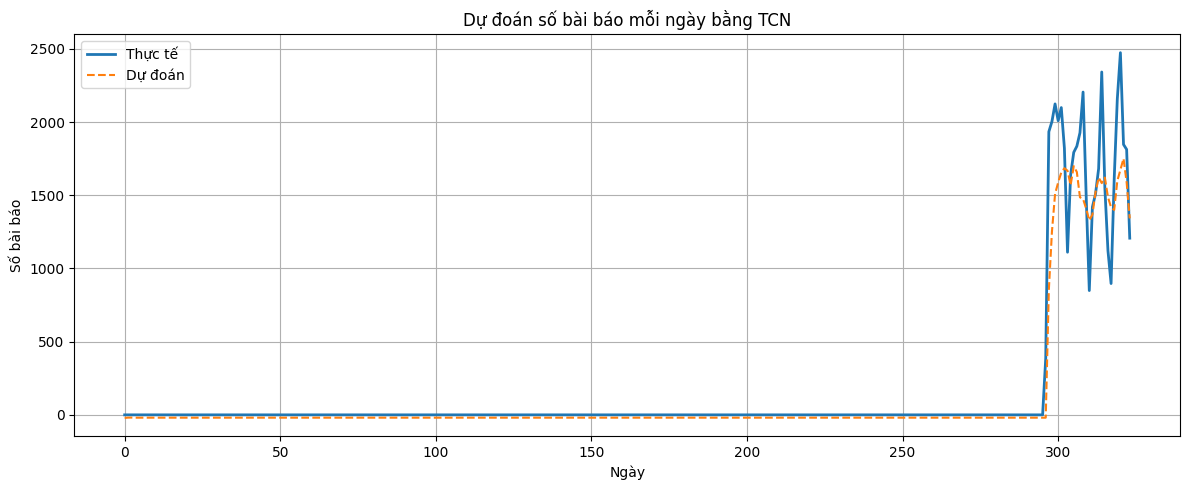

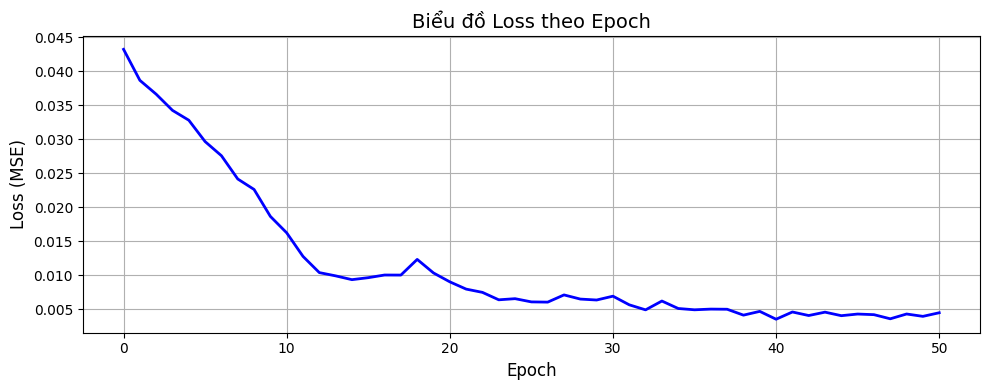

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ========================
# 1. ƒê·ªçc & x·ª≠ l√Ω d·ªØ li·ªáu
# ========================
file_path = "/content/2009_H1N1_Swine_Flu.csv"

df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values(by='date').reset_index(drop=True)
df = df.drop_duplicates(subset=['username', 'text'])
df['OnlyDate'] = df['date'].dt.date

df_daily = df.groupby('OnlyDate').agg({
    'retweets': 'sum',
    'favorites': 'sum',
    'replies': 'sum',
    'text': lambda x: x.astype(str).str.len().mean(),
    'hashtags': lambda x: x.astype(str).str.len().mean()
}).rename(columns={
    'retweets': 'retweets_sum',
    'favorites': 'favorites_sum',
    'replies': 'replies_sum',
    'text': 'text_length',
    'hashtags': 'hashtag_length'
})

article_counts = df.groupby('OnlyDate').size()
df_daily['num_articles'] = article_counts

full_index = pd.date_range(start=df_daily.index.min(), end=df_daily.index.max(), freq='D')
df_daily = df_daily.reindex(full_index).fillna(0)
df_daily.index.name = 'date'

# ========================
# 2. Chu·∫©n h√≥a & t·∫°o d·ªØ li·ªáu
# ========================
def create_multivariate_dataset(data, window_size=20, target_column=0):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size].T)
        y.append(data[i + window_size, target_column])
    return np.array(X), np.array(y)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_daily.values)

window_size = 20
target_column = df_daily.columns.get_loc('num_articles')
X_np, y_np = create_multivariate_dataset(data_scaled, window_size, target_column)

X_tensor = torch.tensor(X_np, dtype=torch.float32)
y_tensor = torch.tensor(y_np, dtype=torch.float32).view(-1, 1)

# ========================
# 3. M√¥ h√¨nh TCN
# ========================
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, padding, dropout=0.3):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.dropout1(self.relu1(self.chomp1(self.conv1(x))))
        out = self.dropout2(self.relu2(self.chomp2(self.conv2(out))))
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation = 2 ** i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            padding = (kernel_size - 1) * dilation
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation, padding, dropout))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCNModel(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.tcn = TemporalConvNet(input_channels, [32, 64, 32])
        self.linear = nn.Linear(32, 1)

    def forward(self, x):
        y = self.tcn(x)
        return self.linear(y[:, :, -1])

# ========================
# 4. Hu·∫•n luy·ªán m√¥ h√¨nh
# ========================
model = TCNModel(input_channels=X_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_loss = float('inf')
patience = 10
counter = 0
epochs = 300
loss_history = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    val_loss = loss.item()
    loss_history.append(val_loss)

    print(f"Epoch {epoch+1}: Loss = {val_loss:.6f}")
    if val_loss < best_loss - 1e-5:
        best_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"‚õî Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model)

# ========================
# 5. ƒê√°nh gi√° m√¥ h√¨nh
# ========================
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

zeros_pad = np.zeros((len(predictions), data_scaled.shape[1]))
zeros_pad[:, target_column] = predictions.ravel()
y_pred = scaler.inverse_transform(zeros_pad)[:, target_column]

zeros_pad[:, target_column] = y_np.ravel()
y_true = scaler.inverse_transform(zeros_pad)[:, target_column]

print("\nüìä Evaluation Metrics:")
print(f"R2 Score:  {r2_score(y_true, y_pred):.4f}")
print(f"MSE:       {mean_squared_error(y_true, y_pred):.4f}")
print(f"MAE:       {mean_absolute_error(y_true, y_pred):.4f}")

# ========================
# 5.5. Ph√¢n lo·∫°i k·∫øt qu·∫£ d·ª± ƒëo√°n th√†nh 3 m·ª©c
# ========================
low_thresh = np.percentile(y_pred, 33)
high_thresh = np.percentile(y_pred, 66)

def classify_level(value):
    if value < low_thresh:
        return "Th·∫•p"
    elif value < high_thresh:
        return "Trung b√¨nh"
    else:
        return "Cao"

pred_levels = np.array([classify_level(val) for val in y_pred])

print("\nüßæ K·∫øt qu·∫£ ph√¢n lo·∫°i d·ª± ƒëo√°n (5 d√≤ng ƒë·∫ßu):")
for i in range(5):
    print(f"Ng√†y {i+1}: D·ª± ƒëo√°n = {y_pred[i]:.2f} ‚Üí M·ª©c = {pred_levels[i]}")

# ========================
# 6. Bi·ªÉu ƒë·ªì k·∫øt qu·∫£
# ========================
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Th·ª±c t·∫ø', linewidth=2)
plt.plot(y_pred, label='D·ª± ƒëo√°n', linestyle='--')
plt.title("D·ª± ƒëo√°n s·ªë b√†i b√°o m·ªói ng√†y b·∫±ng TCN")
plt.xlabel("Ng√†y")
plt.ylabel("S·ªë b√†i b√°o")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ========================
# 7. Bi·ªÉu ƒë·ªì Loss theo Epoch
# ========================
plt.figure(figsize=(10, 4))
plt.plot(loss_history, color='blue', linewidth=2)
plt.title("Bi·ªÉu ƒë·ªì Loss theo Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Xu·∫•t m√¥ h√¨nh ƒë√£ hu·∫•n luy·ªán
# ========================
model_path = "tcn_h1n1_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'input_channels': X_tensor.shape[1]
}, model_path)

print(f"\n‚úÖ M√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u t·∫°i: {model_path}")